In [13]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
from numpy.random import default_rng
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.offline as py

In [100]:
### initialize given values
covariance_v_t0 = 200**2  # (ft/sec)^2
Vc = 300 # ft/sec
covariance_at = 100**2    # (ft/sec^2)^2
tf = 10 # sec
R1 = 15e-6 # rad^2/sec
R2 = 1.67e-3 # rad^2/sec^3
tau = 2 # sec
npts = 1001
timevec = np.linspace(0, tf, npts)
dt = timevec[1] - timevec[0]

### initialize provided matrices in the dynamic equations
F = np.array([
    [0, 1, 0],
    [0, 0, -1],
    [0, 0, -1/tau]
])
G = np.array([0, 0, 1])
W = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, covariance_at]
])
H_bar = np.array([[1, 0, 0]])
P0 = np.array([
    [0, 0, 0],
    [0, covariance_v_t0, 0],
    [0, 0, covariance_at]
]).reshape((9,))
xhat0 = np.array([0, 0, 0])
# K1 = P0[0,0] / (Vc * R1 * (tf) + Vc * R2 / (tf))
# K2 = P0[0,1] / (Vc * R1 * (tf) + Vc * R2 / (tf))
# K3 = P0[0,2] / (Vc * R1 * (tf) + Vc * R2 / (tf))
# K = np.array([K1, K2, K3])
xhat0_and_P0 = np.concatenate((xhat0, P0))

See numpy's [random number generator ref](https://numpy.org/doc/stable/reference/random/generator.html) for more. 
The noise is not Gaussian, but instead looks more like laplace.

It's actually an [Ornstein-Uhlenbeck Process](https://www.lanl.gov/DLDSTP/fast/OU_process.pdf) with zero mean and exponential correlation function. See Section 4 in the link on how to simulate this.

[Simulating a stochastic differential equation in Python](https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/)

In [101]:
def statespace(t, x):
    w_i = np.searchsorted(timevec, t, side='right') - 1
    return F.dot(x) + G.dot(w[w_i])

In [129]:
def kalmanFilter(t, xhat_and_P, z):
    # this function propagates the dynamics of the Kalman Filter
    # inputs:
    # - t: a float representing the current time
    # - xhat_and_P: a numpy array with shape (3, 4) where the elements in the first column (:,0) 
    #               represent the state estimation and the elements in the remaining three columns 
    #               represent the covariance associated with the state estimate
#     print(xhat_and_P.shape)
    xhat = xhat_and_P[0:3]
    P = xhat_and_P[3:].reshape((3,3))
    z_i = np.searchsorted(timevec, t, side='right') - 1
    if z_i == 1000:
        print(t)
    
    # Kalman gains
    K1 = P[0,0] / (Vc * R1 * (tf - t) + Vc * R2 / (tf - t))
    K2 = P[0,1] / (Vc * R1 * (tf - t) + Vc * R2 / (tf - t))
    K3 = P[0,2] / (Vc * R1 * (tf - t) + Vc * R2 / (tf - t))
    # belief state in theta (the LOS angle)
    thetahat = xhat[0] / (Vc*(tf - t))
    # CT equations for the belief state
    xhatdot = np.zeros(3)
    xhatdot[0] = xhat[1] + K1 * (z[z_i] - thetahat) # yhatdot = vhat + K1(z - thetahat)
    xhatdot[1] = -xhat[2] + K2 * (z[z_i] - thetahat)
    xhatdot[2] = -xhat[2]/tau + K3 * (z[z_i] - thetahat)
    # CT equations for the covariance matrix
    Pdot = F.dot(P) + P.dot(F.T) - 1 / (Vc**2 * R1 * (tf - t)**2 + Vc**2 * R2) * P.dot(H_bar.T).dot(H_bar).dot(P) + W
    
    # format the output back into a 1-d array
    xhat_and_P_dot = np.concatenate((xhatdot, Pdot.reshape((9,))))
    
    return xhat_and_P_dot

In [153]:
### Perform the Monte Carlo simulation
# for j in range(10000):
# initialize the state for this run
rng = default_rng()
y0 = 0
v0 = rng.normal(scale=200) # std is 200 ft/sec
aT0 = rng.normal(scale=np.sqrt(covariance_at))
x0 = np.array([0, v0, aT0])

# generate the noise
w = rng.normal(scale=np.sqrt(covariance_at/dt), size=npts) 
# simulate the true state
sol = solve_ivp(statespace, [0, tf], x0, t_eval = timevec)
# calculate the true LOS angle for this run
theta = np.array([sol.y[0,i] / (Vc *(tf - timevec[i])) for i in range(npts-1)]) # up to n-1 to avoid divide by zero
# generate the sensor measurement noise
eta = np.array([(R1 + R2/(tf - timevec[i])**2)/dt for i in range(npts-1)]) # up to n-1 to match theta
# generate the sensor measurment by ading the noise to the true LOS angle
z = theta + eta
# run the CT Kalman Filter to produce state estimates and covariance over time
filtersol = solve_ivp(kalmanFilter, [0, timevec[-2]], xhat0_and_P0, t_eval=timevec[0:-1], args=(z,))

# reconstruct K1, K2, and K3 from the covariance
K1 = [filtersol.y[3,i] / (Vc * R1 * (tf) + Vc * R2 / (tf - filtersol.t[i])) for i in range(filtersol.y.shape[1])]
K2 = [filtersol.y[4,i] / (Vc * R1 * (tf) + Vc * R2 / (tf - filtersol.t[i])) for i in range(filtersol.y.shape[1])]
K3 = [filtersol.y[5,i] / (Vc * R1 * (tf) + Vc * R2 / (tf - filtersol.t[i])) for i in range(filtersol.y.shape[1])]

# reconstruct the standard deviation of each state error from the covariance
std_pos = [np.sqrt(filtersol.y[3,i]) for i in range(filtersol.y.shape[1])]
std_vel = [np.sqrt(filtersol.y[7,i]) for i in range(filtersol.y.shape[1])]
std_accel = [np.sqrt(filtersol.y[11,i]) for i in range(filtersol.y.shape[1])]

In [144]:
print(filtersol.y.shape)
print(filtersol.t.shape)
print(len(K1))

(12, 1000)
(1000,)
1000


See scipy's [odeint ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) or [solve_ivp ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) for more on how to use the functions.

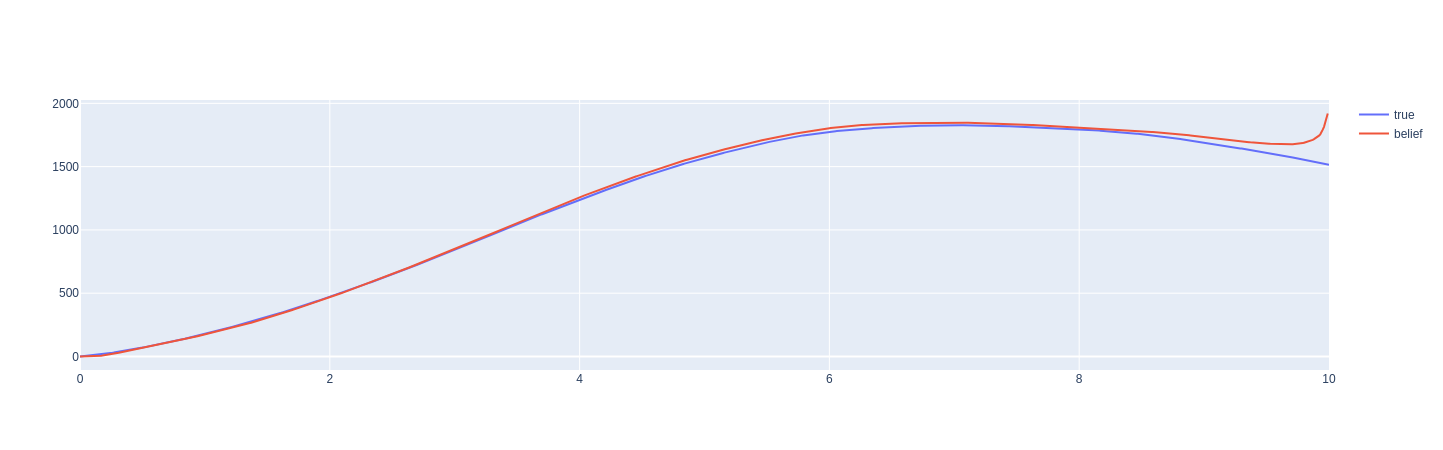

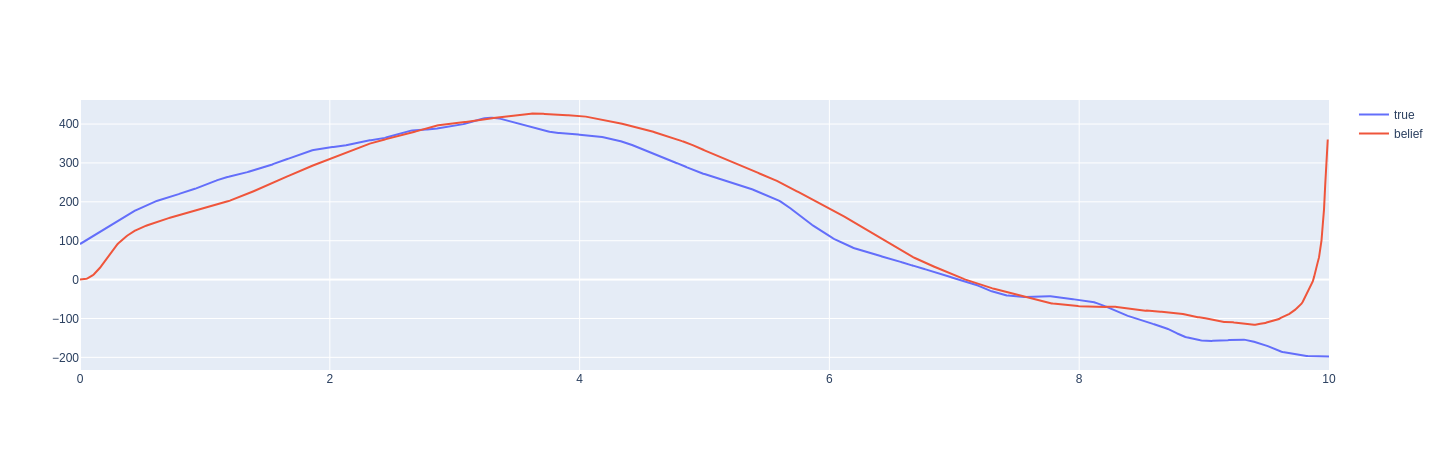

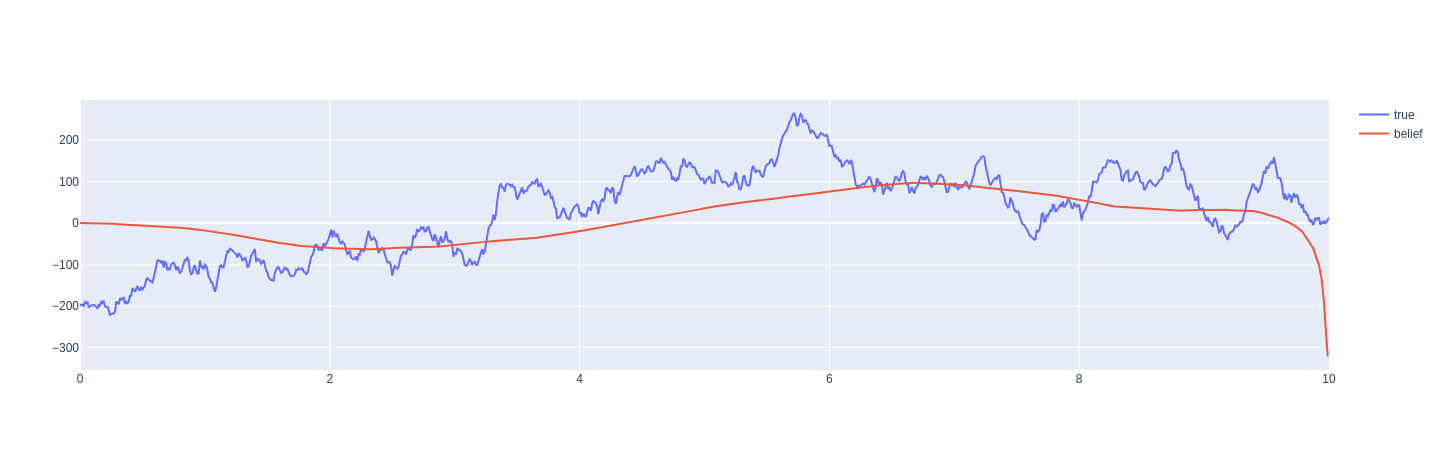

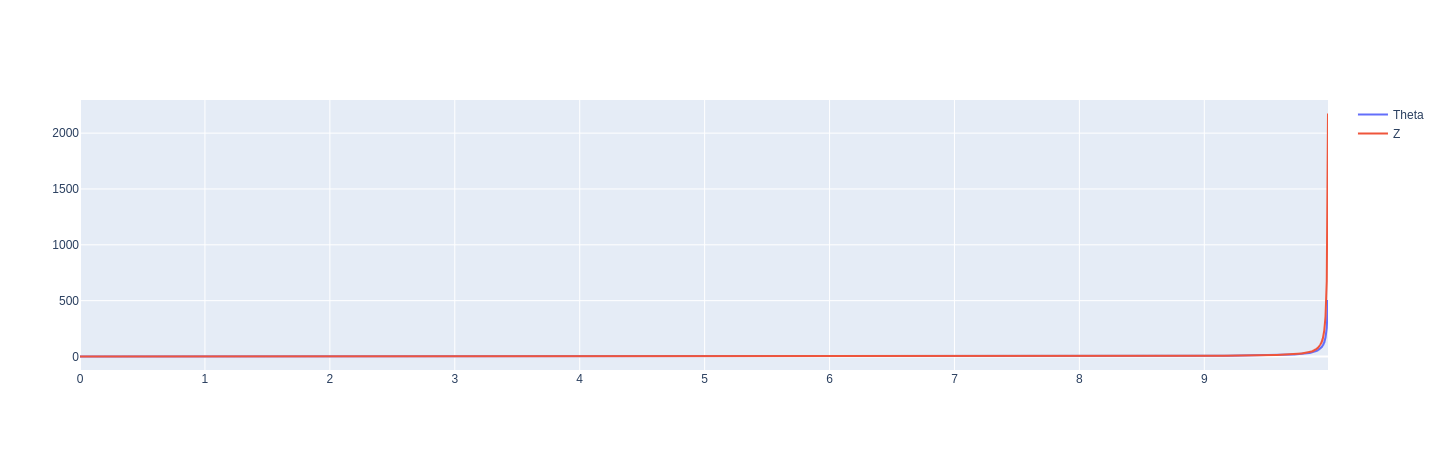

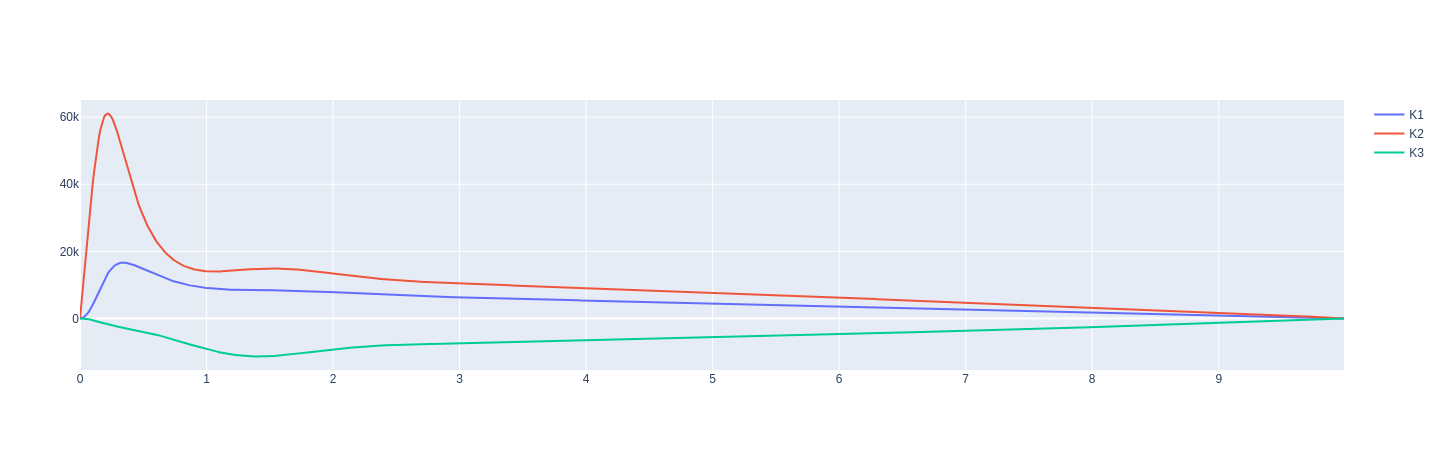

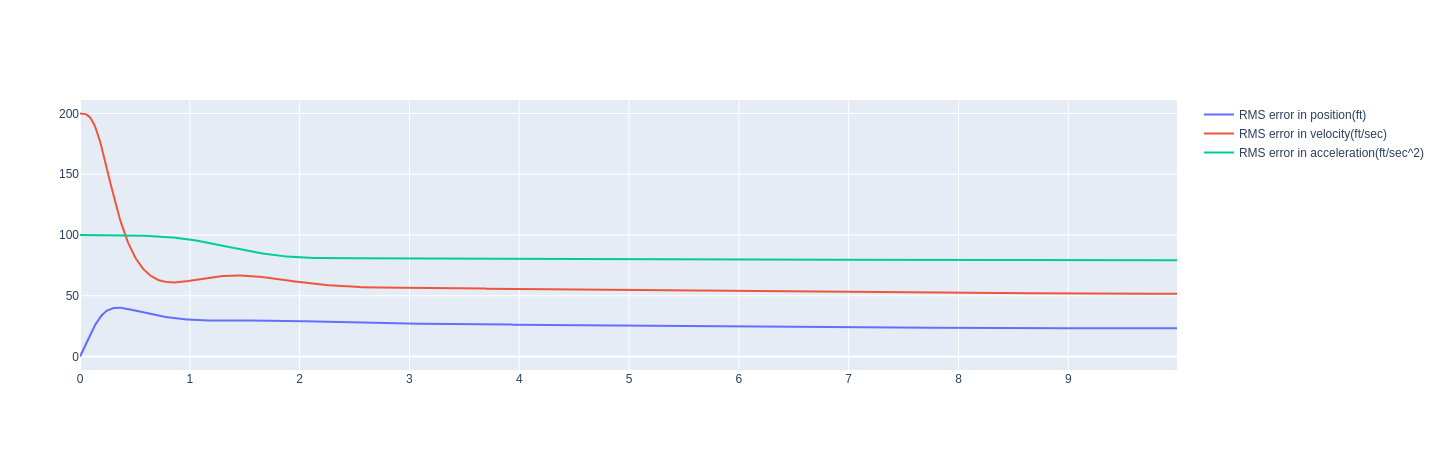

In [155]:
figy = go.Figure()
figy.add_trace(go.Scatter(x=timevec, y=sol.y[0,:], name="true"))
figy.add_trace(go.Scatter(x=timevec[0:-1], y=filtersol.y[0,:], name="belief"))
figy.show()

figv = go.Figure()
figv.add_trace(go.Scatter(x=timevec, y=sol.y[1,:], name='true'))
figv.add_trace(go.Scatter(x=timevec[0:-1], y=filtersol.y[1,:], name='belief'))
figv.show()

figat = go.Figure()
figat.add_trace(go.Scatter(x=timevec, y=sol.y[2,:], name='true'))
figat.add_trace(go.Scatter(x=timevec[0:-1], y=filtersol.y[2,:], name='belief'))
figat.show()

figtheta = go.Figure()
figtheta.add_trace(go.Scatter(x=timevec[0:-1], y=theta, name='Theta'))
figtheta.add_trace(go.Scatter(x=timevec[0:-1], y=z, name='Z'))
figtheta.show()

figk = go.Figure()
figk.add_trace(go.Scatter(x=filtersol.t, y=K1, name='K1'))
figk.add_trace(go.Scatter(x=filtersol.t, y=K2, name='K2'))
figk.add_trace(go.Scatter(x=filtersol.t, y=K3, name='K3'))
figk.show()

figp = go.Figure()
figp.add_trace(go.Scatter(x=filtersol.t, y=std_pos, name='RMS error in position(ft)'))
figp.add_trace(go.Scatter(x=filtersol.t, y=std_vel, name='RMS error in velocity(ft/sec)'))
figp.add_trace(go.Scatter(x=filtersol.t, y=std_accel, name='RMS error in acceleration(ft/sec^2)'))
figp.show()